# Implementación de un algoritmo para encontrar el camino mas corto entre 2 puntos a traves de segmentos que representan obstaculos

### Librerias utilizadas

In [271]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Función que revisa si se intersectan 2 segmentos de recta

In [272]:
def checkIntersection(s1, s2):
    s1vec = s1[1] - s1[0]   # Este fragmento de codigo se utiliza para evitar que los extremos de la recta queden 
    s2vec = s2[1] - s2[0]   # en las intersecciones
    s1[0] += s1vec*0.001    # 
    s1[1] -= s1vec*0.001    # 
                            # 
    s2[0] +=s2vec*0.001     # 
    s2[1] -=s2vec*0.001     # 

    # Algoritmo para encontrar la interseccion de los segmentos, basado en el la idea que se puede ver en:
    # https://pier.guillen.com.mx/algorithms/07-geometricos/07.4-interseccion_segmentos.htm
    s1vec = s1[1] - s1[0]    
    s2vec = s2[1] - s2[0]    
    dist1Vec = s1[0] - s2[0] 
    dist2Vec = s1[1] - s2[1]

    if ((s1vec[0]*dist1Vec[1] - s1vec[1]*dist1Vec[0])*(s1vec[0]*dist2Vec[1] - s1vec[1]*dist2Vec[0]) < -1e-6 and
        (s2vec[0]*dist1Vec[1] - s2vec[1]*dist1Vec[0])*(s2vec[0]*dist2Vec[1] - s2vec[1]*dist2Vec[0]) < -1e-6):
        return True
    elif ((s1vec[0]*dist1Vec[1] - s1vec[1]*dist1Vec[0])*(s1vec[0]*dist2Vec[1] - s1vec[1]*dist2Vec[0]) < 1e-6 and
        (s2vec[0]*dist1Vec[1] - s2vec[1]*dist1Vec[0])*(s2vec[0]*dist2Vec[1] - s2vec[1]*dist2Vec[0]) < 1e-6):
        if np.dot(s1vec, dist1Vec)*np.dot(s1vec, dist2Vec) < 1e-6:
            return True
        elif (np.dot(s1vec, dist1Vec) >= 0 and np.dot(s1vec, dist1Vec) <= np.dot(s1vec, s1vec) 
              or np.dot(s1vec, dist2Vec) <= 0 and np.dot(s1vec, dist1Vec) >= -np.dot(s1vec, s1vec)):
            return True
    return False

checkIntersection(np.array([(1,1),(2,2)], dtype='f'), np.array([(2,1),(0,0)], dtype='f')) # Caso de prueba

False

### Funciónes miscelaneas
La función que aparece aquí se usa para convertir las rectas en algo que matplotlib pueda utilizar para graficar

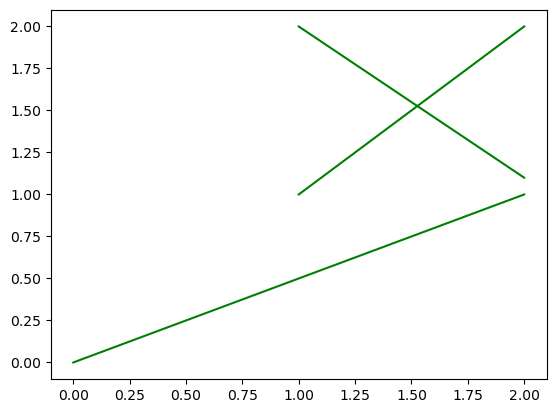

In [273]:
obstacles = (((1, 1), (2, 2)), ((2, 1), (0, 0)), ((2, 1.1), (1, 2))) # (x1, y1), (x2, y2)
def changeLineFormat(lines, intersectSet, color1, color2):
    lineList = []
    for line in lines:
        isInterecting = False
        for li in intersectSet:
            if (checkIntersection(np.array(line, dtype='f'), np.array(li, dtype='f'))):
                isInterecting = True
        lineList += [(line[0][0], line[1][0]), (line[0][1], line[1][1]), color2 if isInterecting else color1]
    return lineList


plt.plot(*changeLineFormat(obstacles, (), 'g', 'r'))

## Encontrar los posibles caminos mas cortos
La función "getAllPosibleConections", se utiliza para generar las posibles aristas del grafo que genera el camino mas corto:
La idea es que el camino mas corto pasa por los extremos de los obstaculos y ademas todas las posibles formas de pasar por estos extremos está dada por el grafo cuyas aristas van de un extremo a otro, luego debemos construir y revisar $(n+2)^2$ aristas, con $n$ el numero de extremos de los obstaculos 

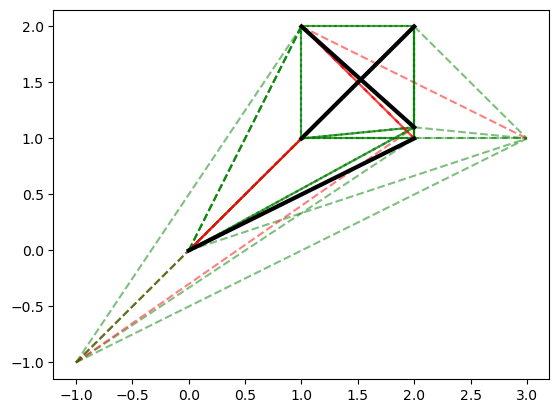

In [274]:
startPos = (-1, -1)
endPos = (3, 1)

def getAllPosibleConections(startPos, endPos, obstacles):
    lines = [(startPos, endPos)]
    # Para las aristas entre start y end solo es necesaria una dirección, hacia afuera y hacia adentro respectivamente
    for obstacle in obstacles:
        lines.append((startPos, obstacle[0]))
        lines.append((startPos, obstacle[1]))
        lines.append((obstacle[0], endPos))
        lines.append((obstacle[1], endPos))

    # Las aristas entre los obstaculos
    for i in range(len(obstacles)):
        for j in range(len(obstacles)):
            if i != j:
                lines.append((obstacles[i][0], obstacles[j][0]))
                lines.append((obstacles[i][0], obstacles[j][1]))
                lines.append((obstacles[i][1], obstacles[j][0]))
                lines.append((obstacles[i][1], obstacles[j][1]))
                lines.append((obstacles[j][0], obstacles[i][0]))
                lines.append((obstacles[j][0], obstacles[i][1]))
                lines.append((obstacles[j][1], obstacles[i][0]))
                lines.append((obstacles[j][1], obstacles[i][1]))

    return lines

possibleLines = getAllPosibleConections(startPos, endPos, obstacles)

# Grafica, los que están en verde son las que no se intersectan y las que están en rojo si se intersectan
plt.plot(*changeLineFormat(possibleLines, obstacles, 'g', 'r'), linestyle='--', alpha=0.5)
plt.plot(*changeLineFormat(obstacles, (), '#000000', '#000000'), linewidth=3)

### Función para encontrar las aristas que no se intersectan con los obstaculos
Si el camino mas corto está en el grafo anterior, ninguna de estas aristas debe chocarse con los obstaculos, la función "notIntersectingLines" remueve las aristas que se intersectan, esta función revisa mas o menos $(n+2)^2$ aristas y las compara con $\frac{n}{2}$ obstaculos, esto es $O(n^3)$

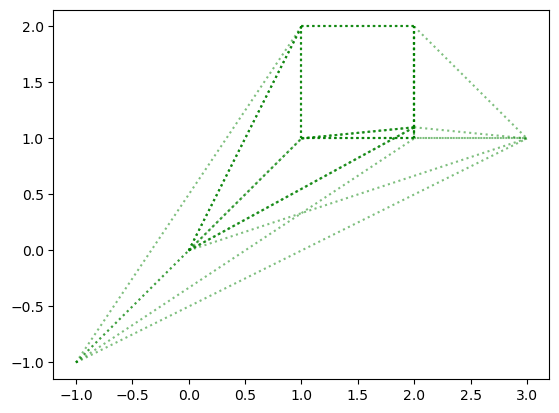

In [275]:
def notIntersectingLines(set1, set2):
    ret = []
    for line1 in set1:
        isIntersecting = False
        for line2 in set2:
            if(checkIntersection(np.array(line1, dtype='f'), np.array(line2, dtype='f'))):
                isIntersecting = True
                break
        if not isIntersecting:
            ret.append(line1)
    return ret

setOfLines = notIntersectingLines(possibleLines, obstacles)
plt.plot(*changeLineFormat(setOfLines, (), 'g', 'r'), linestyle='dotted', alpha=0.5)

### Generar los pesos de las aristas
Se generan los pesos de las aristas y se convierten a un formato legible por la libreria networkX

In [276]:
from math import sqrt
def getWeightedEdges(set):
    res = []
    for line in set:
        res.append((line[0], line[1], sqrt((line[0][0] - line[1][0])**2 + (line[0][1] - line[1][1])**2)))
    return tuple(res)

graphEdges = getWeightedEdges(setOfLines)

### Creación del grafo con pesos para aplicar el algoritmo de Dijkstra

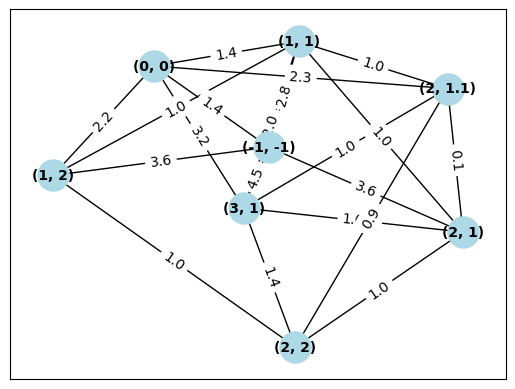

In [277]:
G = nx.Graph()
G.add_weighted_edges_from(graphEdges)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
for label in labels:
    labels[label] = round(labels[label], 1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

### Camino mas corto entre startPos y endPos

In [278]:
shortest_path_lengths, shortest_paths = nx.single_source_dijkstra(G, source=startPos)

# Mostrar el camino mas corto
print("camino más corto desde ", startPos, "hasta ", endPos)
print(shortest_paths[endPos])

camino más corto desde  (-1, -1) hasta  (3, 1)
[(-1, -1), (3, 1)]


In [279]:
print("caminos más cortos desde ", startPos)
for node, path in shortest_paths.items():
    print("Nodo", node, ":", path)

caminos más cortos desde  (-1, -1)
Nodo (-1, -1) : [(-1, -1)]
Nodo (3, 1) : [(-1, -1), (3, 1)]
Nodo (1, 1) : [(-1, -1), (1, 1)]
Nodo (2, 1) : [(-1, -1), (2, 1)]
Nodo (0, 0) : [(-1, -1), (0, 0)]
Nodo (1, 2) : [(-1, -1), (1, 2)]
Nodo (2, 1.1) : [(-1, -1), (0, 0), (2, 1.1)]
Nodo (2, 2) : [(-1, -1), (0, 0), (2, 1.1), (2, 2)]


### Imprimir el camino final con matplotlib

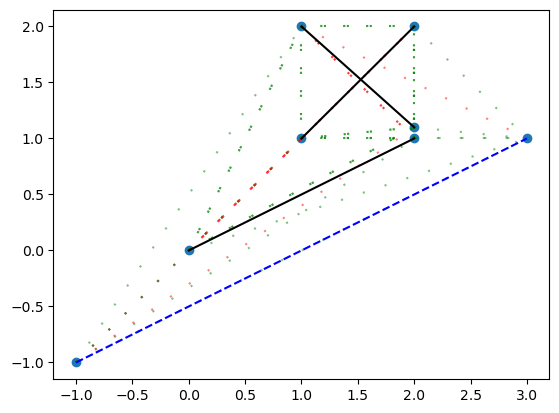

In [280]:
def convertPathToMpRedable(path):
    x = []
    y = []
    for vertex in path:
        x.append(vertex[0])
        y.append(vertex[1])
    return np.array(x), np.array(y)

plt.plot(*changeLineFormat(possibleLines, obstacles, 'g', 'r'), linestyle=(0, (1, 10)), alpha=0.5)  # Las aristas generadas
plt.plot(*changeLineFormat(obstacles, (), '#000000', '#000000'))    # Obstaculos
x, y = convertPathToMpRedable(shortest_paths[endPos])   # Camino mas corto
plt.plot(x, y, 'b', linestyle='--')                     #
xP, yP = convertPathToMpRedable(list(G.nodes))  # Nodos
plt.scatter(xP, yP)                             #

### Funciones que compilan todo el algoritmo para ejecutarse en una sola linea

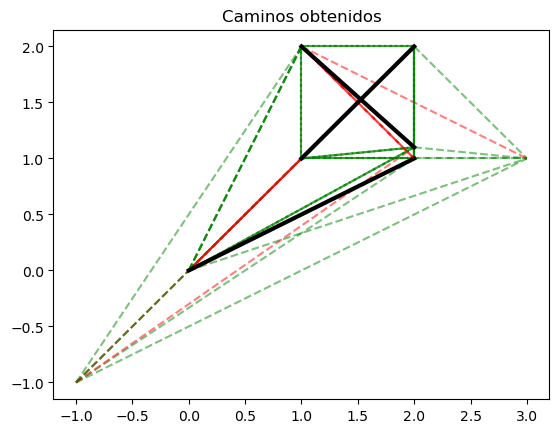

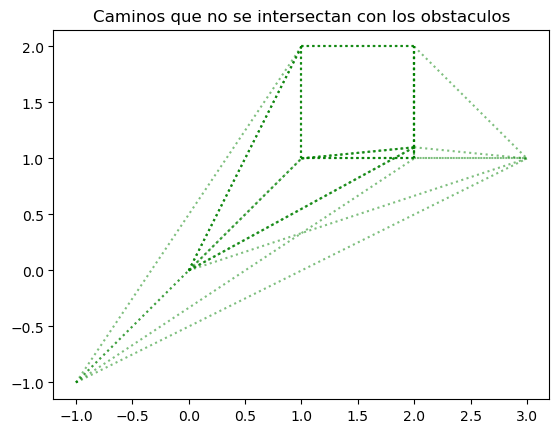

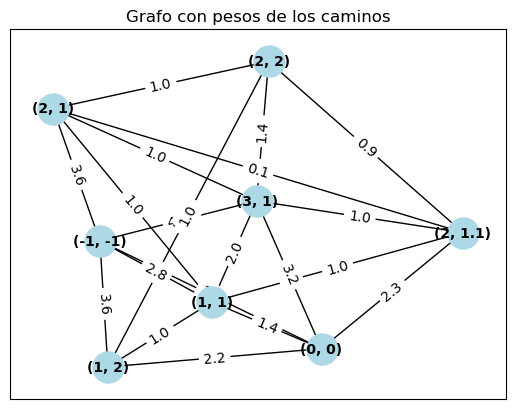

camino más corto desde  (-1, -1) hasta  (3, 1)
[(-1, -1), (3, 1)]


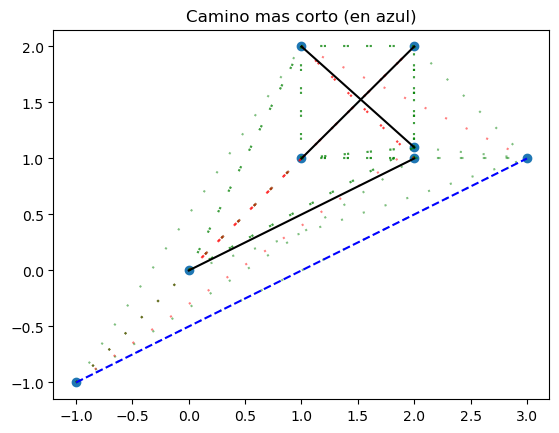

In [281]:
def getShortestPath(startPos, endPos, obstacles):
    possibleLines = getAllPosibleConections(startPos, endPos, obstacles)
    plt.plot(*changeLineFormat(possibleLines, obstacles, 'g', 'r'), linestyle='--', alpha=0.5)
    plt.plot(*changeLineFormat(obstacles, (), '#000000', '#000000'), linewidth=3)
    plt.title("Caminos obtenidos")
    plt.show()
    setOfLines = notIntersectingLines(possibleLines, obstacles)
    plt.plot(*changeLineFormat(setOfLines, (), 'g', 'r'), linestyle='dotted', alpha=0.5)
    plt.title("Caminos que no se intersectan con los obstaculos")
    plt.show()
    graphEdges = getWeightedEdges(setOfLines)
    G = nx.Graph()
    G.add_weighted_edges_from(graphEdges)

    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
    labels = nx.get_edge_attributes(G, 'weight')
    for label in labels:
        labels[label] = round(labels[label], 1)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Grafo con pesos de los caminos")
    plt.show()
    shortest_path_lengths, shortest_paths = nx.single_source_dijkstra(G, source=startPos)
    print("camino más corto desde ", startPos, "hasta ", endPos)
    print(shortest_paths[endPos])
    plt.plot(*changeLineFormat(possibleLines, obstacles, 'g', 'r'), linestyle=(0, (1, 10)), alpha=0.5)
    plt.plot(*changeLineFormat(obstacles, (), '#000000', '#000000'))
    x, y = convertPathToMpRedable(shortest_paths[endPos])
    plt.plot(x, y, 'b', linestyle='--')
    xP, yP = convertPathToMpRedable(list(G.nodes))
    plt.scatter(xP, yP)
    plt.title("Camino mas corto (en azul)")
    plt.show()

def getShortestPath2(startPos, endPos, obstacles): # Solo el ultimo grafico se muestra
    possibleLines = getAllPosibleConections(startPos, endPos, obstacles)
    setOfLines = notIntersectingLines(possibleLines, obstacles)
    graphEdges = getWeightedEdges(setOfLines)
    G = nx.Graph()
    G.add_weighted_edges_from(graphEdges)
    pos = nx.spring_layout(G)
    shortest_path_lengths, shortest_paths = nx.single_source_dijkstra(G, source=startPos)
    print("camino más corto desde ", startPos, "hasta ", endPos)
    print(shortest_paths[endPos])
    plt.plot(*changeLineFormat(possibleLines, obstacles, 'g', 'r'), linestyle=(0, (1, 10)), alpha=0.5)
    plt.plot(*changeLineFormat(obstacles, (), '#000000', '#000000'))
    x, y = convertPathToMpRedable(shortest_paths[endPos])
    plt.plot(x, y, 'b', linestyle='--')
    xP, yP = convertPathToMpRedable(list(G.nodes))
    plt.scatter(xP, yP)
    plt.title("Camino mas corto (en azul)")
    plt.show()

getShortestPath(startPos, endPos, obstacles)

### Algunos ejemplos

camino más corto desde  (-1, -1) hasta  (2, 2)
[(-1, -1), (-2, 1.1), (1, 5), (2, 2)]


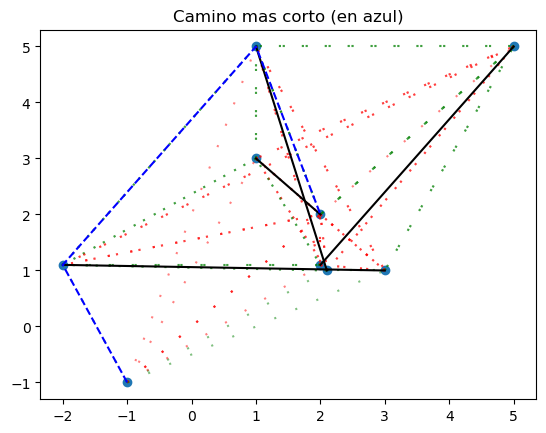

In [286]:
startPos = (-1, -1)
endPos = (2, 2)
obstacles = (((1, 3), (2, 2)), ((2.1, 1), (1, 5)), ((2, 1.1), (5, 5)), ((-2, 1.1), (3, 1)))
getShortestPath2(startPos, endPos, obstacles)

camino más corto desde  (-1, -1) hasta  (6, 2)
[(-1, -1), (3, -1), (7, 1), (6, 2)]


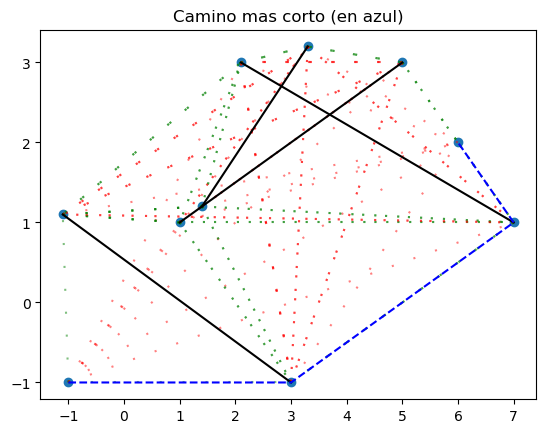

In [288]:
startPos = (-1, -1)
endPos = (6, 2)
obstacles = (((5, 3), (1, 1)), ((2.1, 3), (7, 1)), ((1.4, 1.2), (3.3, 3.2)), ((-1.1, 1.1), (3, -1)))
getShortestPath2(startPos, endPos, obstacles)